# MINIMAX

In [1]:
import optimizers
import minimax
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from numpy.linalg import eig, norm
from matplotlib import cm

In [2]:
def dist(i, j, args):
    i_x = i % args['n']
    i_y = i // args['n']
    j_x = j % args['n']
    j_y = j // args['n']

    return norm([i_x - j_x, i_y - j_y], ord=args['ord'])

args = {}
args['n'] = 10
args['d'] = args['n'] ** 2
i_max = (args['n'] // 2) * (args['n'] + 1) # центральная вершина
args['ord'] = np.inf
args['w'] = np.array([1./(dist(i, i_max, args) + 20) for i in range(args['d'])])
args['theta'] = 1.

args['ord'] = 2
args['A'] = np.zeros((args['d'], args['d']))
for i in range(args['d']):
    for j in range(args['d']):
        args['A'][i,j]=args['w'][i]*(1-np.exp(-args['theta']*dist(i, j, args)))

eigs, _ = eig(args['A'])
args['L'] = 2 * np.max(eigs).real
args['mu'] = 0
x_0 = np.random.random_sample(args['d'])
x_0 = x_0 / norm(x_0, ord=1)
y_0 = np.random.random_sample(args['d'])
y_0 = y_0 / norm(y_0, ord=1)
print(f'L: %.3f' % args['L'])

def f(x, y, args):
    return y.T @ args['A'] @ x

def nabla_f_true(x, y, args):
    return args['A'].T @ y, args['A'] @ x

L: 8.146


In [3]:
# Проекция на симплекс
def projection_simplex(x, args):
    x_sort = sorted(x, reverse=True)
    rho = 0
    summa = x_sort[0]
    summa_ans = x_sort[0]
    
    for i in range(1, len(x_sort)):
        summa += x_sort[i]
        if x_sort[i] + 1 / (i + 1) * (1 - summa) > 0:
            rho = i
            summa_ans = summa

    lamb = 1 / (rho + 1) * (1 - summa_ans)
    x_next = np.zeros(len(x_sort))

    for i in range(len(x_next)):
        x_next[i] = max(x[i] + lamb, 0)
        
    return x_next

100%|██████████| 10000/10000 [00:03<00:00, 3066.17it/s]


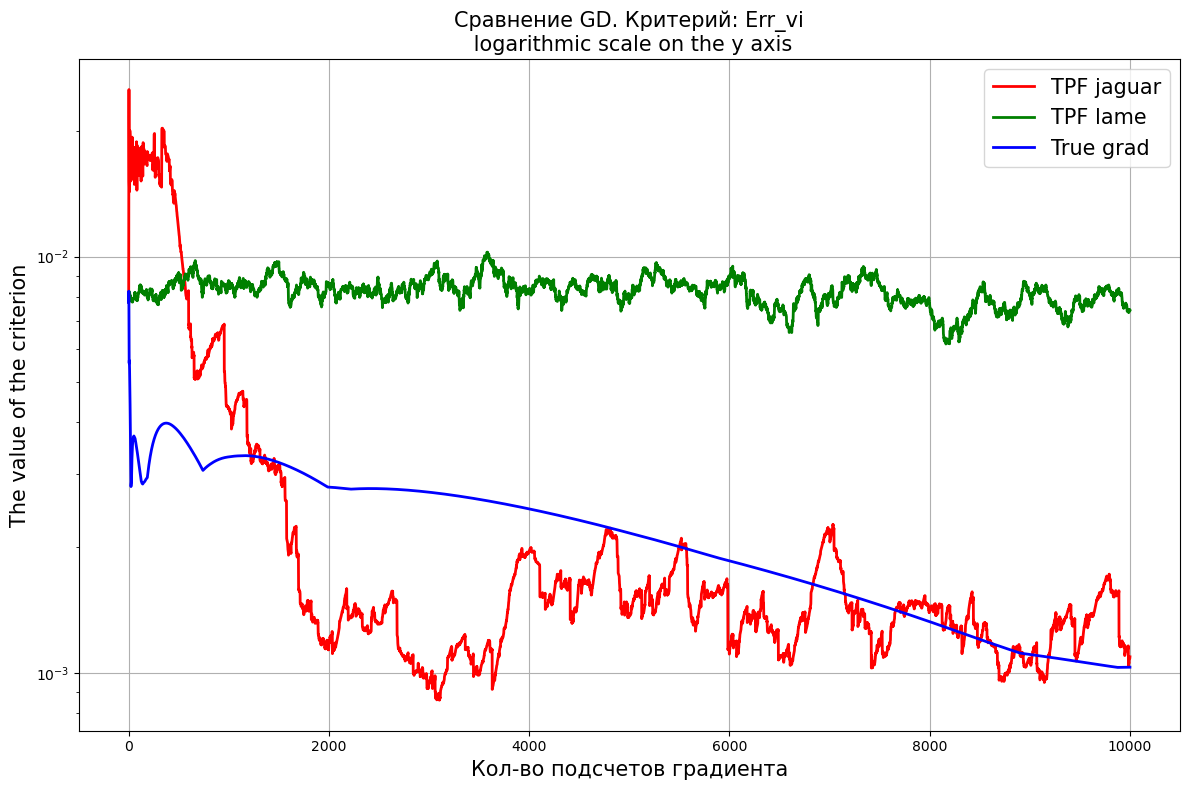

In [24]:
reload(minimax)
def gamma_gd(k, args):
    return (args['c']) / (args['L']**2)
def fw_step(k, args):
    return args['c'] / (k + 3)

iterations_gd = []
errors_gd = []
labels_gd = []
solutions_gd = []
args['batch_size'] = 1
args['sega'] = False
args['func'] = f
args['prob'] = 0
args['oracle_counter'] = 0
args['oracle_calls'] = []
args['gamma'] = lambda k: 1 / np.sqrt(k + 1)
#####
args['grad_curr'] = np.zeros(args['d'])
######
args['h_x'] = np.zeros(args['d'])
args['h_y'] = np.zeros(args['d'])
args['norm'] = 1
max_steps = 10**4
for grad, name in zip([minimax.get_grad_tpf_jaguar, 
                       minimax.get_grad_tpf_lame_v1, 
                       nabla_f_true], ["TPF jaguar", "TPF lame", "True grad"]):
    
    if name == "TPF jaguar":
        args['sega'] = True
        args['c'] = 0.05
        step = gamma_gd
    elif name == "TPF lame":
        args['sega'] = False
        args['c'] = 1000
    else:
        args['c'] = 10
        args['sega'] = False
        step = fw_step
    
    GD = minimax.VariationDescent(f, grad, x_0, y_0,
                                  max_steps=max_steps, criterium='Err_vi', 
                                  gamma_k=step, args=args, 
                                  use_proj=True, 
                                  proj_func=projection_simplex)
    
    x_sol, y_sol, iterations, errors, _ = GD.search()
    iterations_gd.append(iterations)
    errors_gd.append(errors)
    solutions_gd.append((x_sol, y_sol))
    labels_gd.append(name)

title = r"Сравнение GD. Критерий: Err_vi"
optimizers.make_err_plot(iterations_gd, errors_gd, labels=labels_gd, title=title, 
                         x_label="Кол-во подсчетов градиента", markers=[None]*100)

100%|██████████| 100000/100000 [00:16<00:00, 5988.28it/s]


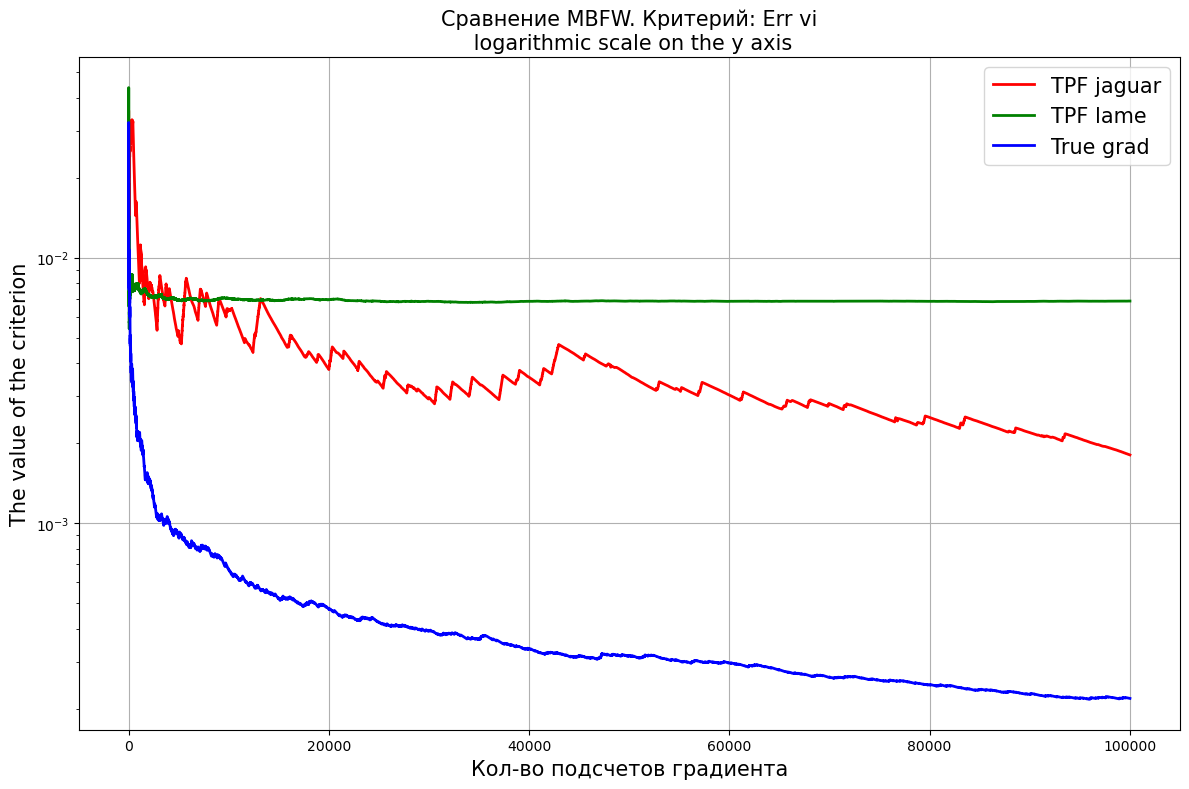

In [26]:
reload(minimax)
def fw_step(k, args):
    return args['c'] / (k + 3)
def momentum_fw(k, args):
    return (k+1) / (k + 3)

iterations_gd = []
errors_gd = []
labels_gd = []
solutions_gd = []
args['func'] = f
args['prob'] = 0
args['grad_x_curr'] = np.zeros(args['d'])
args['grad_y_curr'] = np.zeros(args['d'])
args['h_x'] = np.zeros(args['d'])
args['h_y'] = np.zeros(args['d'])
args['z_x_k'] = np.zeros(args['d'])
args['z_y_k'] = np.zeros(args['d'])
args['norm'] = 1
args['momentum_k'] = momentum_fw

max_steps = 10**5
for grad, name in zip([minimax.get_grad_tpf_jaguar, 
                       minimax.get_grad_tpf_lame_v1, 
                       nabla_f_true], ["TPF jaguar", "TPF lame", "True grad"]):
    
    if name == "TPF jaguar":
        args['sega'] = True
        args['c'] = 2
    elif name == "TPF lame":
        args['sega'] = False
        args['c'] = 2
    else:
        args['c'] = 2
        args['sega'] = False
    
    GD = minimax.VariationDescent(f, grad, x_0, y_0,
                                  max_steps=max_steps, criterium='Err_vi', 
                                  gamma_k=fw_step, args=args, use_mbfw=True)
    
    x_sol, y_sol, iterations, errors, _ = GD.search()
    iterations_gd.append(iterations)
    errors_gd.append(errors)
    solutions_gd.append((x_sol, y_sol))
    labels_gd.append(name)

title = r"Сравнение MBFW. Критерий: Err vi"
optimizers.make_err_plot(iterations_gd, errors_gd, labels=labels_gd, title=title, 
                         x_label="Кол-во подсчетов градиента", markers=[None]*100)